In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.transpiler.passes import Depth
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.circuit import Delay

import matplotlib.pyplot as plt
import math
import numpy as np

import sys
import os

sys.path.append(os.path.abspath("..\\..\\.."))
from objects.shor_code_circuit import ShorCodeCircuit
from functions import *

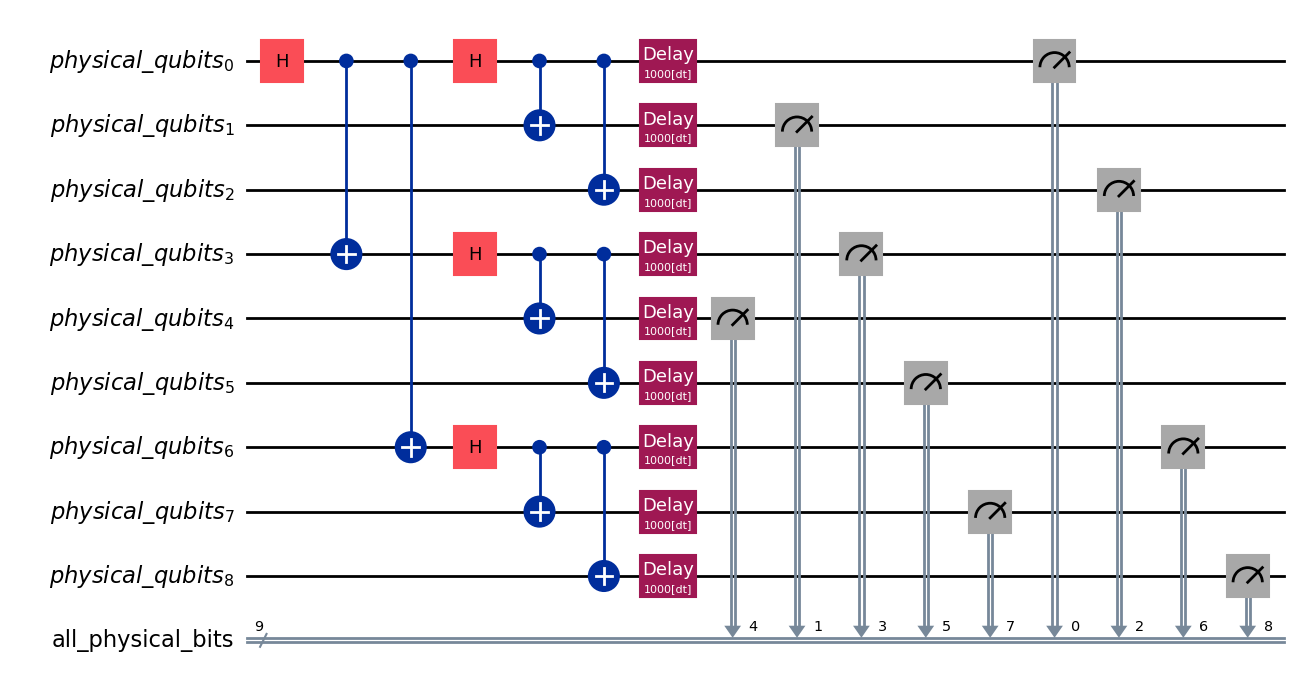

In [3]:
def load_circuit(delay):
    qc = ShorCodeCircuit(1)

    qc.physical_quantum_circuit.h(0)

    qc.encode()

    for i in range(qc.physical_qubit_count):
        qc.append_unitary_error(Delay(delay), i)

    qc.measure_all(basis='all')

    return qc

qc = load_circuit(1000)
qc.draw_physical_circuit('mpl')

In [4]:
ibm_token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token)
backend = service.backend("ibm_sherbrooke")

In [5]:
phy_qc = qc.physical_quantum_circuit
isa_circuit = transpile(phy_qc, backend, scheduling_method="asap", optimization_level=3)
print(f"Circuit Depth: {qc.physical_quantum_circuit.depth()}")
print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")


Circuit Depth: 8
Transpiled Circuit Depth: 33


In [6]:
dt = backend.configuration().dt * 10**9
print(f'dt = {round(dt, 3)} ns')

dt = 0.222 ns


In [7]:
# t_array = [t*10_000 for t in range(0, 21)]
# t_array = [t*20_000 for t in range(0, 3)]
# t_array = [0]
t_array = [t*90_000 for t in range(0, 3)]
print([round(t*dt * 10**(-3), 3) for t in t_array])

[0.0, 20.0, 40.0]


In [8]:
# circuits = []

# for t in t_array:

#     qc = load_circuit(t)

#     isa_circuit = get_transpile(qc.physical_quantum_circuit, backend, iterations=10,
#                                 initial_layout=[30, 29, 31, 17, 28, 32, 27, 35, 36]
#                                 )
#     # isa_circuit = transpile(qc.physical_quantum_circuit, backend, scheduling_method="asap", optimization_level=3,
#     #                         initial_layout=[30, 29, 31, 17, 28, 32, 27, 35, 36]
#     #                         )
    
#     circuits.append(isa_circuit)

#     print(f"Circuit Depth: {circuits[-1].depth()}")
#     print(f"Delay Duration: {round(t*dt * 10**(-3), 3)} us")
#     print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us")
#     print(get_layout(circuits[-1], qb_len=9))
#     print('\n')

In [9]:
simulation_result = sampler_simulation(qc.physical_quantum_circuit, 51200)

print(f"{simulation_result.data[qc.physical_bit_register.name].get_counts()}")


{'000000000': 12769, '111000111': 12879, '000111111': 12810, '111111000': 12742}


In [10]:
sampler = SamplerV2(backend=backend)
shots = 51200
# job = sampler.run(circuits, shots=shots)
# job = sampler.run(circuits[:1], shots=shots)
# job = service.job('cyaqnxfnrmz000863p30') # shots=100, t_array = [t*10_000 for t in range(0, 21)]
# job = service.job('cyqcvz7x46r0008xcwtg') # shots = 51200, t_array = [0]
# job = service.job('cyqd0gj1j2e0008kvd60') # shots = 51200, t_array = [t*20_000 for t in range(0, 3)] -> cancelado!
# job = service.job('cyteq1m78z600082kvj0') # sherbrooke, shots = 51200, t_array = [0] -> se detecta error en qubit 4
# job = service.job('cz4jrhj39f40008scnfg') # sherbrooke, shots = 51200, t_array = [t*90_000 for t in range(0, 3)]
job = service.job('cz4jsqy10wx0008bfcp0') # iteracion 2 -> error en qubit 1 (en ambas iteraciones)

pub_result = job.result()

In [11]:
results = extract_results_IBM(pub_result, type='percentage')[qc.physical_bit_register.name]
delays = [t*dt/1000 for t in t_array]

In [12]:
states = get_possible_states(9)
valid_states = ['111000111', '111111000', '000111111', '000000000']

TVD

In [13]:
alpha = generate_uniform_distribution(9, valid_states=valid_states)


In [14]:
print(*[calculate_tvd(r, alpha)*100 for r in results], sep='\n')

63.8203125
87.869140625
93.11328125


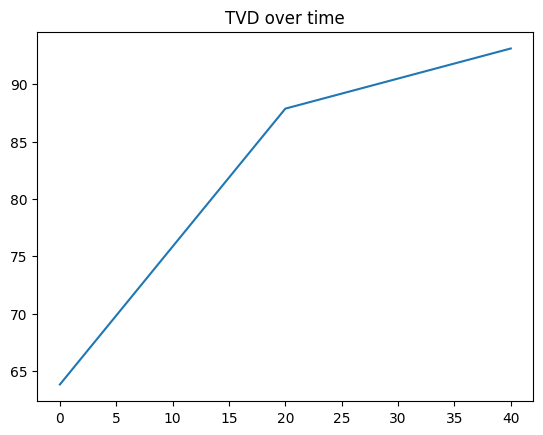

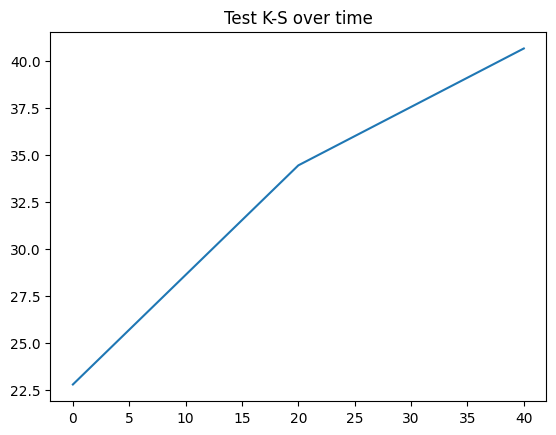

In [15]:
simple_plot(delays, [calculate_tvd(r, alpha)*100 for r in results], title="TVD over time")
simple_plot(delays, [calculate_test_ks(r, alpha)*100 for r in results], title="Test K-S over time")

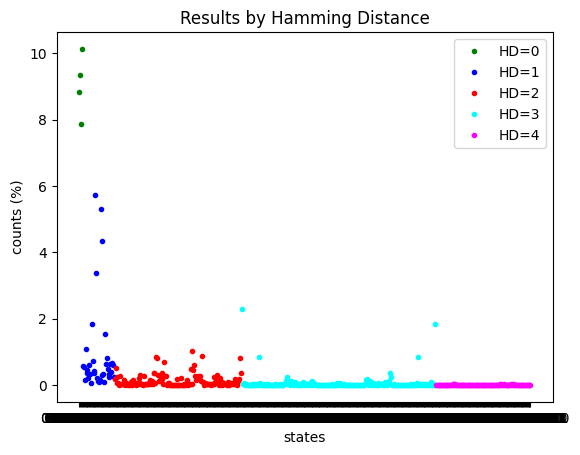

In [23]:
for r in results[:1]:
    plot_results_hamming_distance(r, qb_len=9, valid_states=valid_states)

In [24]:
print_order_results(results[0], valid_states, limit=8)

state: result, HD, error positions
111111000: 10.129%, 0, [[]]
000111111: 9.338%, 0, [[]]
000000000: 8.84%, 0, [[]]
111000111: 7.873%, 0, [[]]
010000000: 5.729%, 1, [[1]]
101000111: 5.309%, 1, [[1]]
101111000: 4.34%, 1, [[1]]
010111111: 3.383%, 1, [[1]]


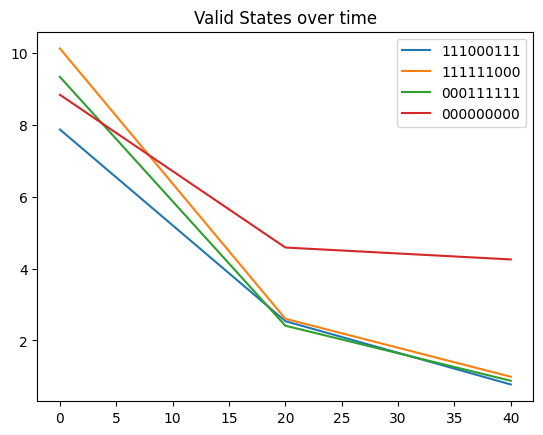

In [17]:
simple_plot(delays, [[r[s] for r in results] for s in valid_states], labels=valid_states, title="Valid States over time")

In [18]:
print_order_results(results[0], valid_states=valid_states, limit=8)

state: result, HD, error positions
111111000: 10.129%, 0, [[]]
000111111: 9.338%, 0, [[]]
000000000: 8.84%, 0, [[]]
111000111: 7.873%, 0, [[]]
010000000: 5.729%, 1, [[1]]
101000111: 5.309%, 1, [[1]]
101111000: 4.34%, 1, [[1]]
010111111: 3.383%, 1, [[1]]


In [19]:
print(f"best TVD: {round(calculate_tvd(results[0], alpha)*100,2)}%")

best TVD: 63.82%


In [20]:
print('test K-S:', calculate_test_ks(results[0], alpha, percentage=True))

test K-S: 0.22804687499999998


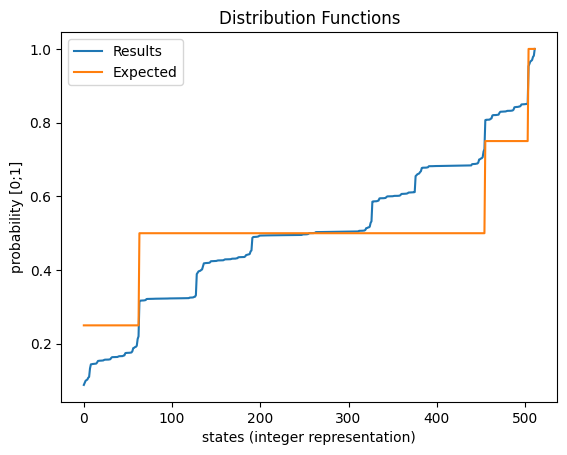

In [21]:
plot_distribution_functions(results[0], alpha)